In [81]:
import os
import datetime
import logging
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr


from ocean_navigation_simulator.utils import units
from ocean_navigation_simulator.utils.misc import get_c3, set_arena_loggers

from ocean_navigation_simulator.reinforcement_learning.missions.CachedNavigationProblem import (
    CachedNavigationProblem,
)
from ocean_navigation_simulator.environment.NavigationProblem import (
    NavigationProblem,
)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
c3 = get_c3()

Starting to connect to c3


In [82]:
experiment_name = "safety_floating_10k_10d"
exp = c3.Experiment.get(experiment_name)

In [83]:
timeout_sim_h = 24 * 10
safe_distance = 2
arena_config = {
    "casadi_cache_dict": {"deg_around_x_t": 2.0, "time_around_x_t": 432000},
    "platform_dict": {
        "battery_cap_in_wh": 400.0,
        "u_max_in_mps": 0.1,
        "motor_efficiency": 1.0,
        "solar_panel_size": 0.5,
        "solar_efficiency": 0.2,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
    },
    "use_geographic_coordinate_system": True,
    "spatial_boundary": None,
    "ocean_dict": {
        "region": "Region 1",
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "data/miss_gen_hindcast/",
                "local": False,
                "source": "Copernicus",
                "type": "hindcast",
                "currents": "total",
            },
        },
        "forecast": None,
    },
    "bathymetry_dict": {
        "field": "Bathymetry",
        "source": "gebco",
        "source_settings": {
            "filepath": "ocean_navigation_simulator/package_data/bathymetry_and_garbage/bathymetry_global_res_0.083_0.083_max.nc"
        },
        "distance": {
            "safe_distance": safe_distance,
            "filepath": "ocean_navigation_simulator/package_data/bathymetry_and_garbage/bathymetry_distance_res_0.083_0.083_max_elevation_-150.nc",
        },
        "casadi_cache_settings": {"deg_around_x_t": 10},
        "use_geographic_coordinate_system": True,
    },
    "garbage_dict": {
        "field": "Garbage",
        "source": "Lebreton",
        "source_settings": {
            "filepath": "ocean_navigation_simulator/package_data/bathymetry_and_garbage/garbage_patch_global_res_0.083_0.083.nc"
        },
        "casadi_cache_settings": {"deg_around_x_t": 10},
        "use_geographic_coordinate_system": True,
    },
    "solar_dict": {"hindcast": None, "forecast": None},
    "seaweed_dict": {"hindcast": None, "forecast": None},
}
config = {
    ##### Target Sampling #####
    # HYCOM HC: lon [-98.0,-76.4000244140625], lat[18.1200008392334,31.92000007629394]
    # Copernicus FC: lon: [-98.0, -76.416664], lat: [18.083334, 30.0]
    # Combined: [-98.0, -76.416664], [18.1200008392334, 30.0]
    # GOM
    "x_range":[-160, -105], 
    "y_range":[15, 40],
    # Region 1
    # "x_range": [-159, -106],
    # "y_range": [16, 39],
    # "x_range": [-160, -105],
    # "y_range": [15, 40],
    "t_range": [  # ['2022-08-01T00:00:00+00:00', '2022-08-30T00:00:00+00:00'],
        # Copernicus FC: 2022-04 until today, HYCOM Hindcast: 2021-09 until today
        datetime.datetime(year=2022, month=1, day=1, tzinfo=datetime.timezone.utc),
        datetime.datetime(year=2022, month=12, day=31, tzinfo=datetime.timezone.utc),
    ],
    "problem_timeout_in_h": timeout_sim_h,  # to be considered as feasible
    "problem_target_radius": 0.1,
    ##### HJ Planner #####
    "hj_specific_settings": {
        # 'grid_res' has to be smaller than target_radius to prevent hj_solver errors
        "grid_res": 0.02,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
        "direction": "multi-time-reach-back",
        "n_time_vector": 199,  # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
        "accuracy": "high",
        "artificial_dissipation_scheme": "local_local",
        "run_without_x_T": True,
        "progress_bar": False,
        "T_goal_in_seconds": 3600 * timeout_sim_h,
        "deg_around_xt_xT_box": 1.0,  # area over which to run HJ_reachability
    },
    "hj_planner_box": 2.0,
    ##### Start Sampling #####
    "feasible_missions_per_target": 4,
    "feasible_mission_time_in_h": [timeout_sim_h*0.5, timeout_sim_h*0.9],
    "random_missions_per_target": 0,
    "random_min_distance_from_target": 0.5,
    "min_distance_from_hj_frame": 0.5,
    "min_distance_from_land": 0.025,
    #"random_min_distance_from_target": 0.5,
    # Safety specific values
    #"max_distance_from_land": 3,
    #"min_distance_from_garbage": 0,
    #"max_distance_from_garbage": 0,
    ##### Actions #####
    "plot_batch": False,
    "animate_batch": False,
    "cache_forecast": False,
    "cache_hindcast": False,
    ##### Distance maps #####
    "filepath_distance_map": {
        "bathymetry": "ocean_navigation_simulator/package_data/bathymetry_and_garbage/bathymetry_distance_res_0.083_0.083_max_elevation_-150.nc",
        "garbage": "ocean_navigation_simulator/package_data/bathymetry_and_garbage/garbage_patch_distance_res_0.083_0.083_max.nc",
    },
}
objectiveConfig = {"type": "nav"}
assert timeout_sim_h > config["feasible_mission_time_in_h"][1], "Timeout set to an unfeasibly small value"
km_per_deg = 110
assert config["min_distance_from_land"]*km_per_deg > safe_distance, "Shouldn't sample missions that fail in first timestep"


In [84]:
if type(config["t_range"][0]) == str:
    config["t_range"] = [datetime.datetime.fromisoformat(t) for t in config["t_range"]]
max_time_delta = (config["t_range"][1]-config["t_range"][0]) - datetime.timedelta(hours=config["problem_timeout_in_h"], days=1)
distance_map = xr.open_dataset(
                config["filepath_distance_map"]["bathymetry"]
            )

In [85]:
exp = c3.Experiment.createNew(
    name=experiment_name,
    description="10k floating",
    arenaConfig=arena_config,
    objectiveConfig=objectiveConfig,
    timeout_in_sec=3600 * timeout_sim_h,
)
# Stupid
exp.experimentName = experiment_name

In [86]:
num_points = 10000
on_land = 0
runs = []
missions = []
i = 0
while len(runs) < num_points:
    # Sample geospatial coordinates
    lon = np.random.uniform(config["x_range"][0]+0.5, config["x_range"][1]-0.5)
    lat = np.random.uniform(config["y_range"][0]+0.5, config["y_range"][1]-0.5)
    date_time = config["t_range"][0] + datetime.timedelta(days=np.random.uniform(0, max_time_delta.days))

    distance_to_shore = distance_map.interp(lon=lon, lat=lat)["distance"].data
    # Check for on land
    if distance_to_shore < config["min_distance_from_land"]*111:    # Sample datetime range            miss_number = 0
        on_land += 1
        continue
    i+=1
    missionConfig = {'x_0': [{'lon': lon,
        'lat': lat,
        'date_time': date_time.isoformat()}],
        'x_T': {'lon': 0, 'lat': 0},
        'target_radius': 0.1,
        'seed': i,
        'feasible': True,
        'ttr_in_h': 500}

    name = "mission_nr_" + str(i)    
    mission = c3.Mission(**{
        'id': exp.id + "_" + name,
        'status': 'staged_for_feasibility',
        'experiment': exp.id,
        'missionConfig': missionConfig,
        'fundamentalFeasibility': missionConfig.get('feasible', None),
        'T_earliest_in_hours': missionConfig.get('ttr_in_h', None)
    })

    # create the mission
    mission.create()
    runs.append(missionConfig)
    missions.append(mission)

_ = c3.Mission.mergeBatch(missions)

print(f"Rejection rate: {on_land / num_points}")

Rejection rate: 0.172


In [87]:
m_remove = exp.get("expMissions").expMissions
len(m_remove)

10000

In [79]:
for m in m_remove:
    #m.remove()


In [48]:
problems = []
for run in runs:
    problems.append(CachedNavigationProblem.from_c3_mission_config(run))
print(len(problems))

1000


In [50]:
results_folder = f"{os.getcwd()}/"
df = pd.DataFrame([problem.to_dict() for problem in problems])
df["factory_index"] = 0
df.to_csv(results_folder + "problems.csv")

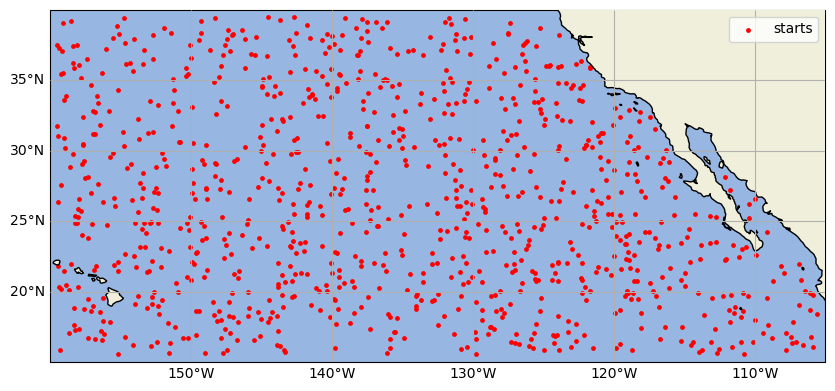

In [51]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_title("Time: " + datetime.fromtimestamp(time, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC'))

ax.add_feature(cfeature.LAND, zorder=3, edgecolor="black")
ax.add_feature(cfeature.OCEAN, zorder=0)
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.axis(xmin=config["x_range"][0], xmax=config["x_range"][1])
ax.axis(ymin=config["y_range"][0], ymax=config["y_range"][1])
# ax.axis(xmin=-160, xmax=-105)
#ax.axis(ymin=15, ymax=40)
# TODO: adapt Generation runner to use nice plotting
for miss_idx in range(len(df)):
    ax.scatter(
        df.iloc[miss_idx]["x_0_lon"],
        df.iloc[miss_idx]["x_0_lat"],
        c="red",
        marker="o",
        s=6,
        label="starts" if miss_idx == 0 else None,
    )
#ax.scatter(df["x_T_lon"], df["x_T_lat"], c="green", marker="x", s=12, label="targets")
ax.legend()
# ax.get_figure().savefig(f"{analysis_folder}starts_and_targets.png")
#ax.get_figure().show()

In [ ]:
# import pandas as pd


# def get_results_df(this):
#     # get all runs from the database (NOTE this can only get 2000 at a time!)
#     exp_filter = "mission.experiment.id==" + '"' + this.get("experimentName").experimentName + '"'
#     all_exp_runs = c3.OceanSimRun.fetch(
#         spec={
#             "include": "[this]",
#             "filter": exp_filter,
#             "order": "ascending(mission.id)",
#             "limit": -1,
#         }
#     ).objs
#     # get a list of all termination reasons
#     termination_reason = []
#     status = []
#     arrival_time = []
#     minDistanceToTarget = []
#     ctrl_obs_name = []
#     mission_ids = []

#     for run in all_exp_runs:
#         # get mission_id
#         mission_ids.append(run.get("mission").mission.id)
#         # get ctrl_obs setting
#         ctrl_obs_name.append(
#             run.get("controllerSetting.name").controllerSetting.name
#             + "__"
#             + run.get("observerSetting.name").observerSetting.name
#         )
#         # add outcomes
#         termination_reason.append(run.terminationReason)
#         status.append(run.status)
#         arrival_time.append(run.T_arrival_time)
#         minDistanceToTarget.append(run.minDistanceToTarget)

#     # Make a df out of it
#     df = pd.DataFrame(
#         list(
#             zip(
#                 mission_ids,
#                 ctrl_obs_name,
#                 status,
#                 termination_reason,
#                 arrival_time,
#                 minDistanceToTarget,
#             )
#         ),
#         columns=[
#             "mission_id",
#             "setting",
#             "status",
#             "termination_reason",
#             "arrival_time",
#             "minDistance",
#         ],
#     )

#     return df